# Naive Bayes, SVC and Random Forest for disease prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import statistics

Function to load the train and test data (separate files for both)

In [2]:
def load_data(train_path, test_path):
    train_data = pd.read_csv(train_path).dropna(axis=1)
    test_data = pd.read_csv(test_path).dropna(axis=1)
    return train_data, test_data

Function to encode the target (to nunmerical value) and split the data

In [3]:
def preprocess_data(data):
    encoder = LabelEncoder()
    data["prognosis"] = encoder.fit_transform(data["prognosis"])
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    return X, y, encoder

Function to plot the distribution of the diseases

In [4]:
def plot_disease_distribution(data):
    disease_counts = data["prognosis"].value_counts()
    plt.figure(figsize=(18, 8))
    sns.barplot(x=disease_counts.index, y=disease_counts.values, palette="viridis")
    plt.title("Disease Distribution", fontsize=16)
    plt.ylabel("Count", fontsize=14)
    plt.xlabel("Disease", fontsize=14)
    plt.xticks(rotation=90, fontsize=12)
    plt.tight_layout()
    plt.show()

Function to train all of the models and print their results

In [5]:
def train_models(X, y):
    models = {
        "SVC": SVC(),
        "Gaussian NB": GaussianNB(),
        "Random Forest": RandomForestClassifier(random_state=18)
    }
    
    results = []
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=10, n_jobs=-1, scoring="accuracy")
        results.append({
            "Model": name,
            "Mean Accuracy": np.mean(scores),
            "Accuracy Std Dev": np.std(scores)
        })
        print(f"{name} - Mean Accuracy: {np.mean(scores):.2f}, Std Dev: {np.std(scores):.2f}")
    
    return pd.DataFrame(results), models


Function to train a single model and generate its confussion matrix

In [6]:
def train_single_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    cf_matrix = confusion_matrix(y_test, preds)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap="coolwarm", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=16)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f"Accuracy on Test Data ({model_name}): {accuracy * 100:.2f}%")
    return model, accuracy

Function to make final predictions

In [7]:
def predict_disease(symptoms, data_dict, models):
    symptoms = symptoms.split(",")
    input_data = [0] * len(data_dict["symptom_index"])
    for symptom in symptoms:
        index = data_dict["symptom_index"].get(symptom.strip().capitalize(), None)
        if index is not None:
            input_data[index] = 1

    input_data = np.array(input_data).reshape(1, -1)
    predictions = [model.predict(input_data)[0] for model in models.values()]
    final_prediction = statistics.mode(predictions)
    return {
        "SVC Prediction": data_dict["predictions_classes"][predictions[0]],
        "Naive Bayes Prediction": data_dict["predictions_classes"][predictions[1]],
        "Random Forest Prediction": data_dict["predictions_classes"][predictions[2]],
        "Final Prediction": data_dict["predictions_classes"][final_prediction]
    }

Load the data

In [8]:
train_path = "data/training_data.csv"
test_path = "data/testing_data.csv"
train_data, test_data = load_data(train_path, test_path)
train_data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


In [9]:
test_data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,GERD
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chronic cholestasis
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Drug Reaction


Visualize the data

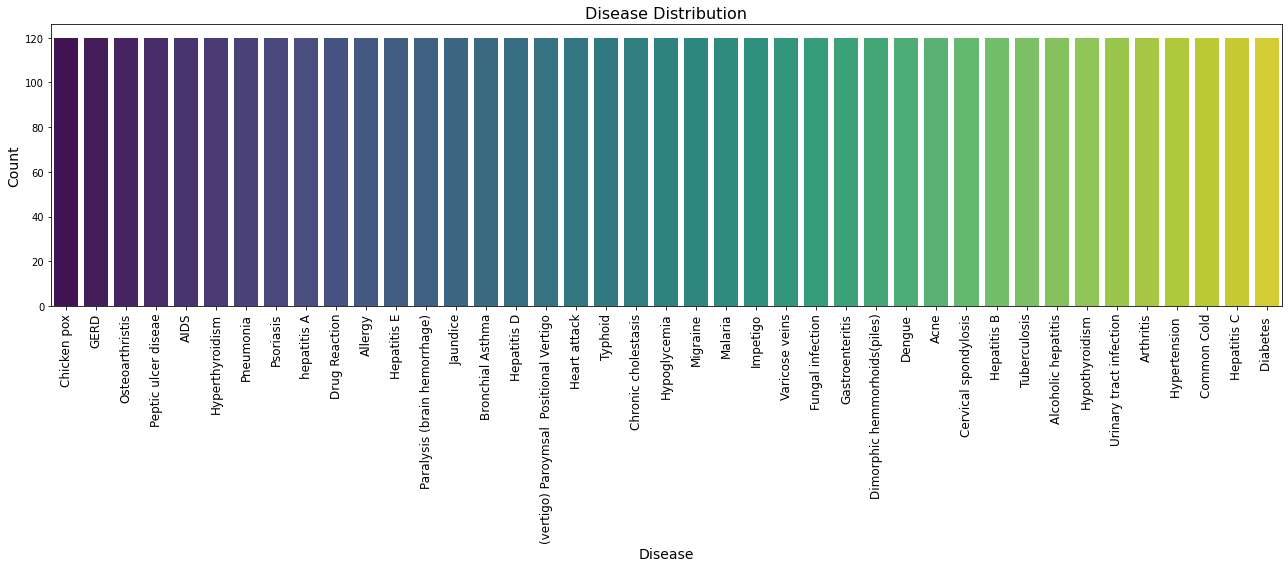

In [10]:
plot_disease_distribution(train_data)

Split the data and train the models

In [11]:
# Preprocess Data
X, y, encoder = preprocess_data(train_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Train Models
results, models = train_models(X, y)
results

SVC - Mean Accuracy: 1.00, Std Dev: 0.00
Gaussian NB - Mean Accuracy: 1.00, Std Dev: 0.00
Random Forest - Mean Accuracy: 1.00, Std Dev: 0.00


,Model,Mean Accuracy,Accuracy Std Dev
0,SVC,1.0,0.0
1,Gaussian NB,1.0,0.0
2,Random Forest,1.0,0.0


Conclusion: The models are very accurate on the test data, that's why the mean value of the accuracy is 1.0 and the standard deviation of the accuracy is 0.0. 

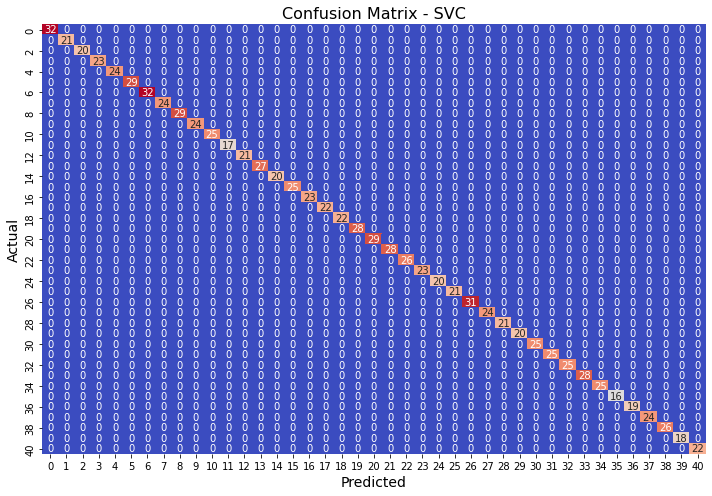

Accuracy on Test Data (SVC): 100.00%


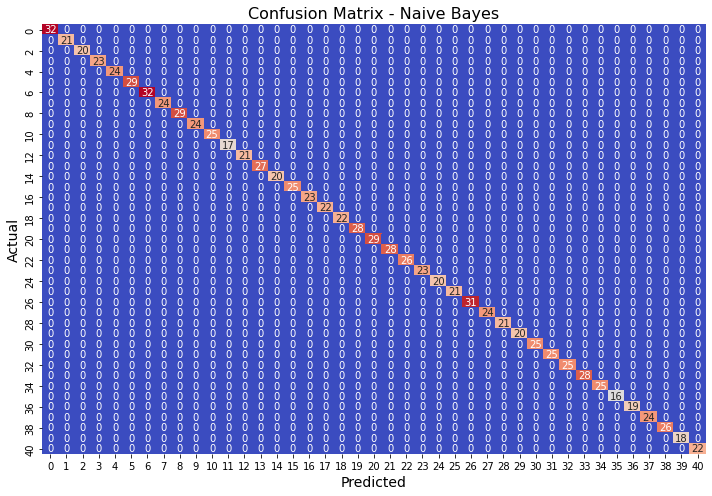

Accuracy on Test Data (Naive Bayes): 100.00%


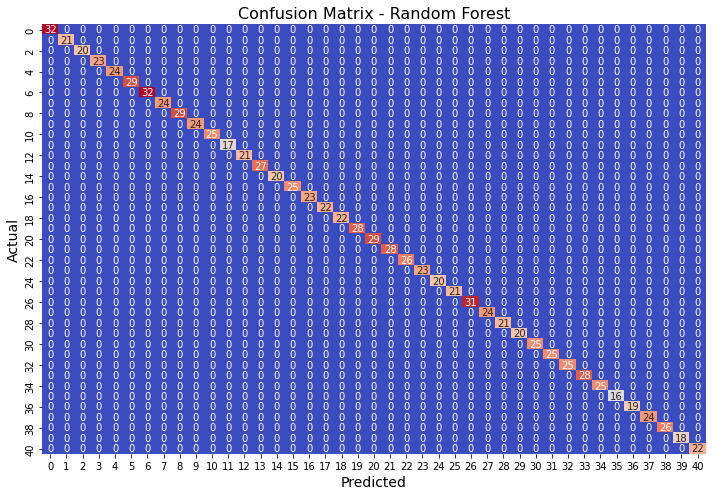

Accuracy on Test Data (Random Forest): 100.00%
Predictions for Symptoms 'Itching,Skin Rash,Nodal Skin Eruptions':
                                         0
SVC Prediction            Fungal infection
Naive Bayes Prediction    Fungal infection
Random Forest Prediction  Fungal infection
Final Prediction          Fungal infection


In [12]:
# Train Individual Models and Visualize Results
svc_model, svc_acc = train_single_model(models["SVC"], X_train, y_train, X_test, y_test, "SVC")
nb_model, nb_acc = train_single_model(models["Gaussian NB"], X_train, y_train, X_test, y_test, "Naive Bayes")
rf_model, rf_acc = train_single_model(models["Random Forest"], X_train, y_train, X_test, y_test, "Random Forest")

# Combine Models for Final Prediction
data_dict = {
    "symptom_index": {symptom.replace("_", " ").capitalize(): idx for idx, symptom in enumerate(X.columns)},
    "predictions_classes": encoder.classes_
}
final_models = {"SVC": svc_model, "Naive Bayes": nb_model, "Random Forest": rf_model}

# Test the Prediction Function
test_symptoms = "Itching,Skin Rash,Nodal Skin Eruptions"
predictions = predict_disease(test_symptoms, data_dict, final_models)
print(f"Predictions for Symptoms '{test_symptoms}':\n{pd.DataFrame(predictions, index=[0]).T}")

Conclusion: All of the models achieved 100% accuracy on the test data.